# W207.6 Final Project - Predicting Cancer Type from Tumor Mutations
## Notebook 4 - Visualize Performance
### Tony Di Sera, Vijay Singh, Rajiv Nair, Jeremey Fraenkel


## Initialization

In [0]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
from textwrap import wrap
import matplotlib.pyplot as plt
from IPython.display import display
import time
from IPython.core.interactiveshell import InteractiveShell

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({'figure.max_open_warning': 0})

# Establish the colors for each cancer type
label_colors = []
cm = plt.get_cmap('tab20b')
for i in range(20):
    label_colors.append(cm(i))
cm = plt.get_cmap('tab20c')
for i in range(13):
    label_colors.append(cm(i))

In [0]:
#from google.colab import drive
#drive.mount('/content/drive/')


In [2]:
cd /content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project/final_notebooks

/content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project/final_notebooks


In [0]:
# create the directory where the downloaded directory is stored
data_dir = "./data"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
# create the directory where the metrics are stored
metrics_dir = "./metrics"
if not os.path.isdir(metrics_dir):
    os.makedirs(metrics_dir)
    
# create the raw where the source data is stored
raw_dir = "./raw"
if not os.path.isdir(raw_dir):
    os.makedirs(raw_dir)    

In [4]:
# This downloads a dictionary file
dictionary_filename = "./raw/tcga_dictionaries.txt"
if os.path.isfile(dictionary_filename):
    print("Skipping download, as file %s is present" %(dictionary_filename))
else:
    print('Downloading dictionary file...')
    url = 'https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt'  
    urllib.request.urlretrieve(url, dictionary_filename)  
print("done.")


# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

Skipping download, as file ./raw/tcga_dictionaries.txt is present
done.


## Visualize Performance across different feature sets, different classifiers

In [0]:
def get_saved_metrics():
    metrics_filename = "./metrics/metrics.csv"
    if os.path.isfile(metrics_filename):
        metrics_df = pd.read_csv(metrics_filename)
        metrics =  [row for row in metrics_df.T.to_dict().values()]
        return metrics
    else:
        return []
      
def get_saved_metrics_dataframe():
    metrics_filename = "./metrics/metrics.csv"
    if os.path.isfile(metrics_filename):
        metrics_df = pd.read_csv(metrics_filename)
        return metrics_df
    else:
        return None

def save_metrics(name, classifier, metrics, prf_by_label, confusion_mx):
    
    metrics_df = pd.DataFrame(metrics, columns=['name', 'classifier', 'feature_size', 
                                                'accuracy', 'precision', 'recall', 'f1', 
                                                'time'])
    
    # Write out scores as csv files
    metrics_df.to_csv("./metrics/metrics.csv")
    
    # Write out confusion matrix to csv file    
    confusion_mx_df = pd.DataFrame.from_dict(confusion_mx)
    filename = "./metrics/confusion_" + name + "_" + classifier + ".csv"
    confusion_mx_df.to_csv(filename)
    
    # Write out precision, recall, f1 by class to csv file
    prf_by_label_df = pd.DataFrame(prf_by_label)
    prf_by_label_list = []
    for row in prf_by_label:
      prf_by_label_list.append(list(row))
    prf_by_label_df = pd.DataFrame(prf_by_label_list)
    filename = "./metrics/prf_by_class_" + name + "_" + classifier + ".csv"
    prf_by_label_df.to_csv(filename)
    
def get_prf_by_label(name, classifier):
    filename = "./metrics/prf_by_class_" + name + "_" + classifier + ".csv"
    if os.path.isfile(filename):
        prf_by_label_df = pd.read_csv(filename)
        return prf_by_label_df[prf_by_label_df.columns[1:]]
    else:
        return None
    
def get_confusion_matrix(name, classifier):
    filename = "./metrics/confusion_" + name + "_" + classifier + ".csv"
    if os.path.isfile(filename):
        confusion_df = pd.read_csv(filename)
        return confusion_df[confusion_df.columns[1:]]
    else:
        return None
      
def calculate_metrics(name, classifier, feature_size, predict, test_labels, 
                      elapsed_time, metrics):
    # Get precision, recall, f1 scores
    prf_scores          = precision_recall_fscore_support(test_labels, predict, 
                                                          average='weighted')
    acc_score           = accuracy_score(test_labels, predict)
    prf_by_label        = precision_recall_fscore_support(test_labels, predict, 
                                                          average=None)
    classification_rpt  = classification_report(test_labels, predict)

    # Get confusion matrix
    conf_mx             = confusion_matrix(test_labels, predict)

    metrics.append({
     'name':               name,
     'classifier':         classifier,
     'feature_size':       feature_size,
     'accuracy':           acc_score,
     'precision':          prf_scores[0],
     'recall':             prf_scores[1],
     'f1':                 prf_scores[2],
     'time':               elapsed_time 
    })
    save_metrics(name, classifier, metrics, prf_by_label, conf_mx)



### Load the metrics data

In [0]:
metrics_df = get_saved_metrics_dataframe()
metrics_df = metrics_df.sort_values(by=['feature_size', 'name', 'classifier'], ascending=[1,1,1])
metrics_df = metrics_df[metrics_df.columns[1:]]

metrics_df = metrics_df.sort_values(by=['classifier', 'feature_size', 'name'], ascending=[1,1,1])

In [0]:
colors = {'lr': 'olivedrab', 'svm': 'slateblue', 
          'dt': 'mediumseagreen', 'rf': 'goldenrod',
          'xgb': 'coral', 'nn': 'crimson'}

def plot_classifier_metrics(metrics_df, label_encoder, description):
    
    plt.rcParams["figure.figsize"] = (20,14)

    labels = []
    for key, group in metrics_df.groupby(['feature_size', 'name']):
        labels.append(str(key[0]) + ' features \n' + key[1])
    

    sorted_df_report = metrics_df.sort_values(by=['classifier', 'feature_size', 'name'], ascending=[1,1,1])


        
    for classifier, group in sorted_df_report.groupby(['classifier']):

        plt.plot(labels, group.precision.values, color=colors[classifier], 
                 linewidth=2, label=classifier + " precision", marker='o' )
        plt.plot(labels, group.recall.values, color=colors[classifier], linestyle="dashed",
                 linewidth=2, label=classifier + " recall", marker='o' )
    

    plt.yticks(np.arange(0, .70, .01))
    plt.title(description, fontsize=20)
    plt.ylabel('Precision, Recall', fontsize=14)
    plt.xlabel('Feature Sets', fontsize=14, labelpad=14)
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.grid()
    plt.show()
    
    for classifier, group in sorted_df_report.groupby(['classifier']):

        plt.plot(labels, group.accuracy.values, color=colors[classifier], 
                 linewidth=2, label=classifier + " accuracy", marker='o' )
    

    plt.yticks(np.arange(0, .70, .01))
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(rotation='vertical')
    plt.xlabel('Features and Classifiers', fontsize=14, labelpad=20)
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_classifier_times(metrics_df, label_encoder, description):
    
    plt.rcParams["figure.figsize"] = (20,6)

    labels = []
    for key, group in metrics_df.groupby(['feature_size', 'name']):
        labels.append(str(key[0]) + '\n' + key[1])
        
    sorted_df_report = metrics_df.sort_values(by=['classifier', 'feature_size', 'name'], ascending=[1,1,1])


        
    for classifier, group in sorted_df_report.groupby(['classifier']):

        plt.plot(labels, group.time.values, color=colors[classifier], 
                 linewidth=2, label=classifier + " precision", marker='o' )
        
    

    plt.ylabel('Time to train and predict', fontsize=14)
    plt.xlabel('Feature Sets', fontsize=14, labelpad=14)
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.grid()
    plt.show()
    

    
def coords_of_max(theArray, n):
    # Flatten the 2D array
    flat = theArray.flatten()
    # Partition so that the we know the sort order for
    # the cells with the highest values.  We just
    # care about the top n highest values.  So for example,
    # if n = 3, get return 3 indices.  
    indices = np.argpartition(flat, -n)[-n:]
    # Reverse so that we show index of highest value first
    # (descending)
    indices = indices[np.argsort(-flat[indices])]
    # Now return the coordinates for these indices
    # for a 2D array.  This will return 2 arrays,
    # the first for the row index, the second for the
    # column index.  The row index represents the
    # actual digit, the column index represents
    # the confused digit
    return np.unravel_index(indices, theArray.shape)
  


### Plot precision metrics across different classifiers and feature sets

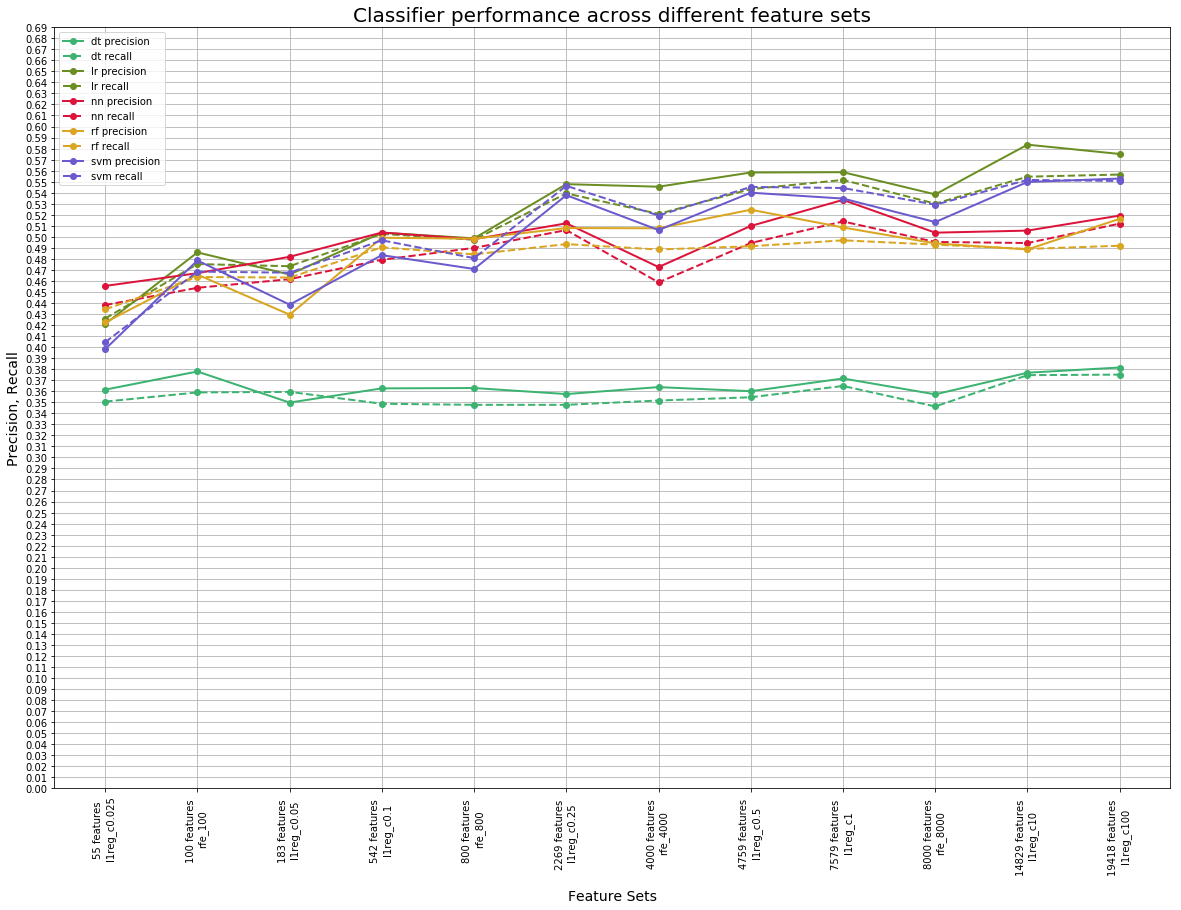

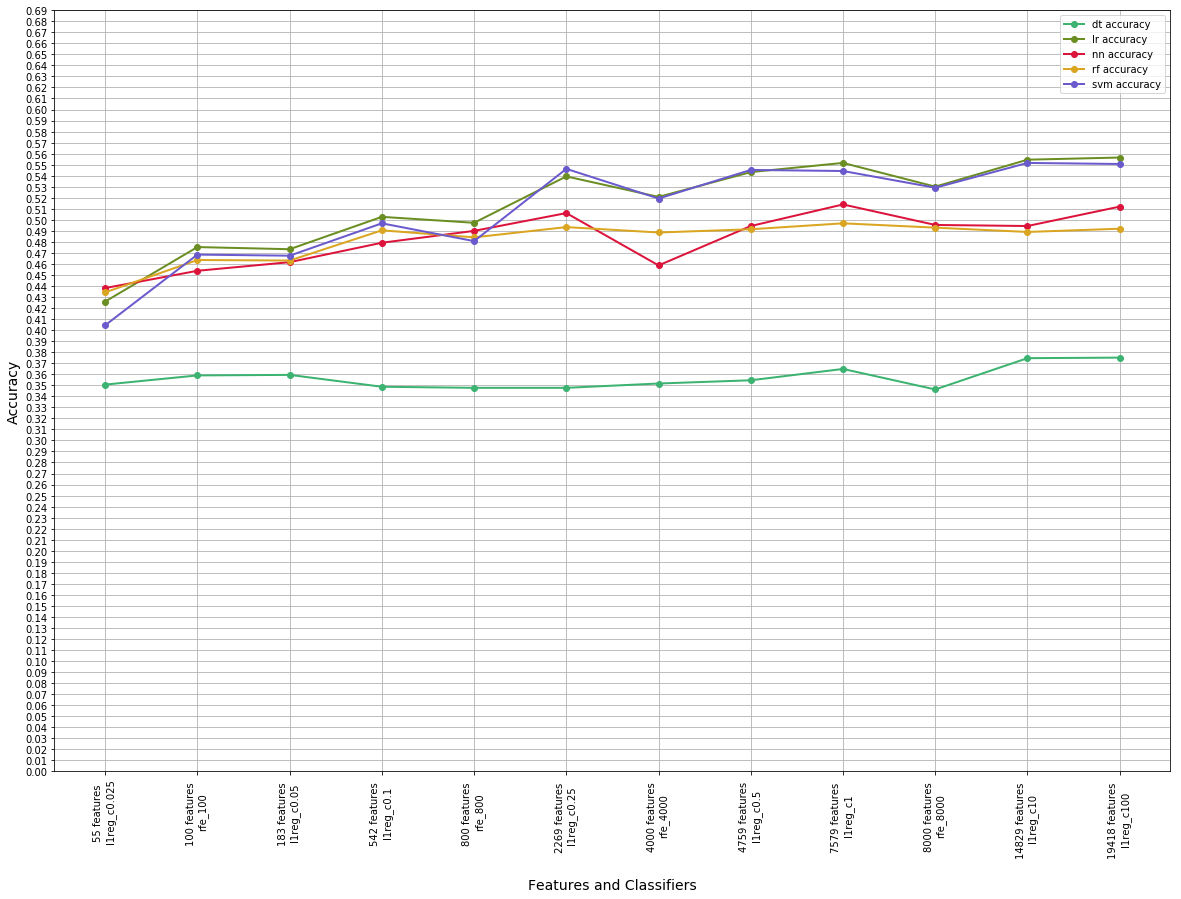

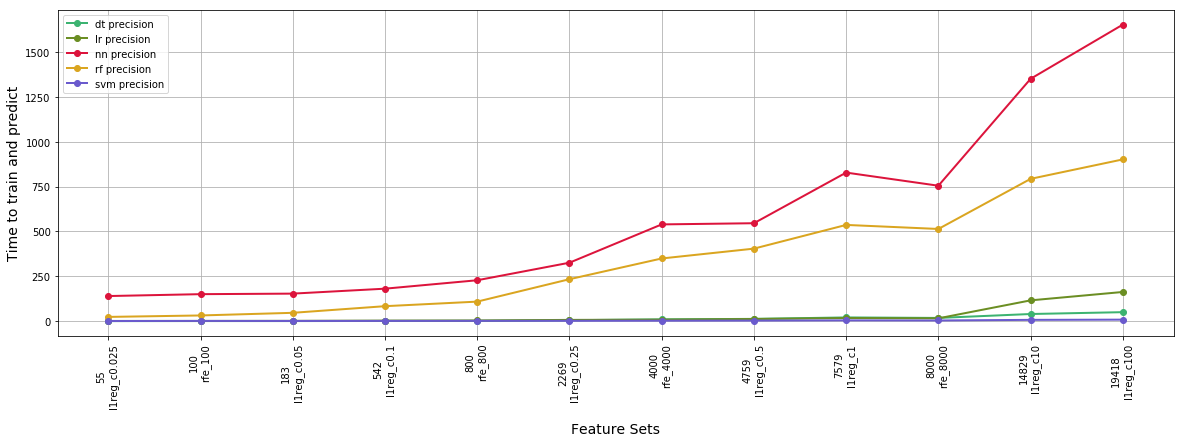

In [13]:
label_encoder   = preprocessing.LabelEncoder()

#metrics_df = metrics_df[~metrics_df.name.isin(['all'])]
                        

# Plot precision, recall, accuracy across different classifiers
# for somatic mutations
plot_classifier_metrics(metrics_df, label_encoder, 'Classifier performance across different feature sets')

# Plot time across different classifiers
# for somatic mutations
plot_classifier_times(metrics_df, label_encoder, 'Time to train and run each model')


### Report the precision, recall, and f1 score across different classifiers and feature sets



Best precision


,name,classifier,feature_size,accuracy,precision,recall,f1,time
30,l1reg_c10,lr,14829,0.554523,0.583559,0.554523,0.528981,115.661529




Best recall


,name,classifier,feature_size,accuracy,precision,recall,f1,time
35,l1reg_c100,lr,19418,0.556479,0.575112,0.556479,0.53414,162.381875




Best f1


,name,classifier,feature_size,accuracy,precision,recall,f1,time
35,l1reg_c100,lr,19418,0.556479,0.575112,0.556479,0.53414,162.381875




Best accuracy


,name,classifier,feature_size,accuracy,precision,recall,f1,time
35,l1reg_c100,lr,19418,0.556479,0.575112,0.556479,0.53414,162.381875


best name l1reg_c10


LabelEncoder()



Precision and Recall by Label with Best F1 score 
Classifier: lr Feature set: l1reg_c10


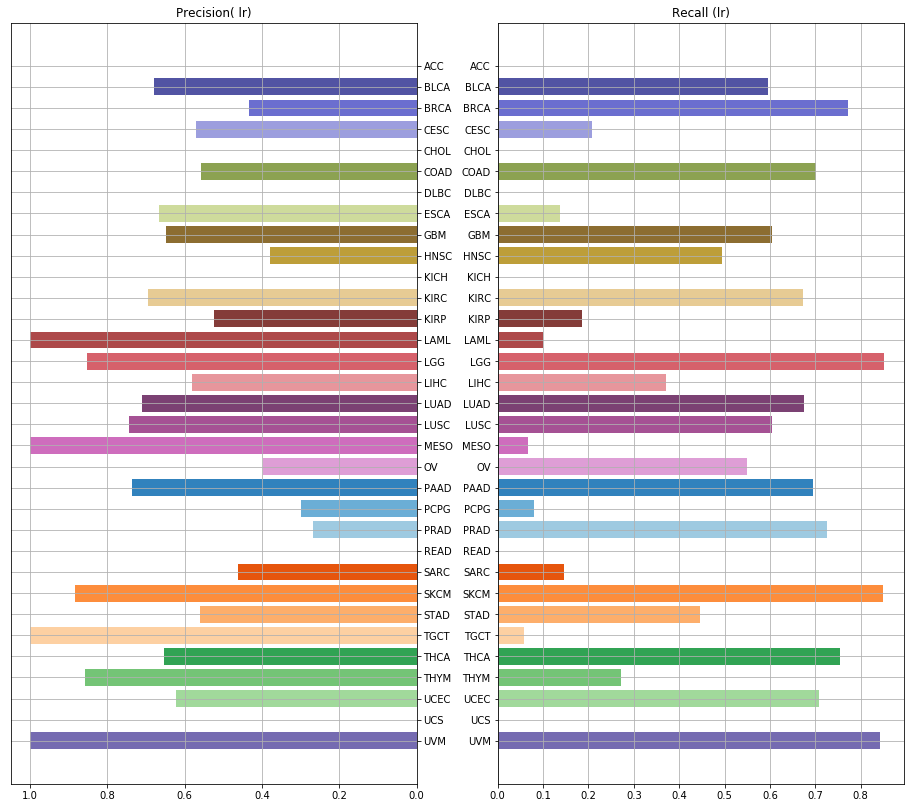

In [11]:
def show_precision_recall_by_label(prf_by_label_df, name, classifier, label_encoder):
    
    plt.rcParams["figure.figsize"] = (16,14)
    
    labels = []
    for i in range(prf_by_label_df.shape[1]):
        label = label_encoder.inverse_transform([i])[0]
        labels.append(label)
    
    
    y_pos = np.arange(len(labels))    

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    ax1.invert_xaxis()
    ax1.invert_yaxis()
    ax1.yaxis.tick_right()
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    
    ax2.invert_yaxis()
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
        
    ax1.barh(y_pos, prf_by_label_df.iloc[0].values, color=label_colors , label="precision")
    ax2.barh(y_pos, prf_by_label_df.iloc[1].values, color=label_colors,  label='recall')

    ax1.set_title('Precision( ' + classifier + ')')
    ax2.set_title('Recall (' + classifier + ')')
    ax1.grid()
    ax2.grid()
    

    plt.show()



# best precision
sorted_df = metrics_df.sort_values(by='precision', ascending=0)
best_precision = sorted_df.head(1)

# best recall
sorted_df = metrics_df.sort_values(by='recall', ascending=0)
best_recall = sorted_df.head(1)

# best f1
sorted_df = metrics_df.sort_values(by='f1', ascending=0)
best_f1 = sorted_df.head(1)

# best accuracy
sorted_df = metrics_df.sort_values(by='accuracy', ascending=0)
best_accuracy = sorted_df.head(1)


# Show the feature set and classifier with the best 
# precision, recall, and f1 scores
print("\n\nBest precision")
display(best_precision)
print("\n\nBest recall")
display(best_recall)
print("\n\nBest f1")
display(best_f1)
print("\n\nBest accuracy")
display(best_accuracy)

# get the scores by label and confusion matrix
# for the best prediction
best_prediction = best_precision
best_name       = best_prediction.name.values[0]
best_classifier = best_prediction.classifier.values[0]


print("best name", best_name)

best_prf_by_label_df = get_prf_by_label(best_name, best_classifier)
best_confusion_mx_df = get_confusion_matrix(best_name, best_classifier)

feature_matrix = pd.read_csv("./data/features_" + best_name + ".train.csv")
label_encoder.fit(feature_matrix.cancer_type.unique())

# show a side-by-side barchart of precision and recall for each label
print("\n\nPrecision and Recall by Label with Best F1 score ")
print("Classifier:", best_classifier, "Feature set:", best_name)
show_precision_recall_by_label(best_prf_by_label_df,
                               best_name, best_classifier, label_encoder)
                                                      


## Visualizations for Diagnosing Poor Performing Classes

### How many genes are in common for a cancer type?

In [0]:
features       = feature_matrix[feature_matrix.columns[1:]]
cancer_types   = sorted(features.cancer_type.unique())
best_precision = np.round(best_prf_by_label_df.iloc[0],2)
best_recall    = np.round(best_prf_by_label_df.iloc[1],2)

plt.rcParams["figure.figsize"] = (11,35)
fig = plt.figure()
suptitle = fig.suptitle("Number of Genes in Common for Samples of a Cancer Type", fontsize=20)
ax = fig.subplots(11, 3, sharex=False, sharey=False, squeeze=True)
plt.subplots_adjust(hspace=0.4)
ax = ax.flatten()

num_samples_per_cancer_type = []
num_genes_per_cancer_type   = []
num_multisample_genes_per_cancer_type = []
pct_multisample_genes_per_cancer_type = []
avg_num_samples_sharing_genes = []


for idx, cancer_type in enumerate(cancer_types, start=0):
  features_ct = features.loc[features.cancer_type == cancer_type]
  features_ct = features_ct[features_ct.columns[2:]]

  print(".", end='')

  
  gene_sums_all = features_ct.sum(axis=0) 
  gene_sums_all = gene_sums_all[gene_sums_all > 0]
  gene_sums = gene_sums_all[gene_sums_all > 1]
  gene_sums.columns = ['gene_count']

  
  num_samples_per_cancer_type.append(features_ct.shape[0])
  num_genes_per_cancer_type.append(gene_sums_all.shape[0])
  num_multisample_genes_per_cancer_type.append(gene_sums.shape[0])
  pct_multisample_genes_per_cancer_type.append((gene_sums.shape[0] / gene_sums_all.shape[0]) * 100)
  avg_num_samples_sharing_genes.append(gene_sums.mean(axis=0))
  
  bins = np.arange(31) - 0.5
  _ = gene_sums.hist(ax=ax[idx], bins=bins, density=True, range=[0,31], color=label_colors[idx] )
  _ = ax[idx].set_title(cancer_type + "\n" 
                        + str(best_precision[idx]) + " prec, " + str(best_recall[idx]) + " recall \n"
                        + str(gene_sums_all.shape[0]) + " genes, " + str(features_ct.shape[0]) + " samples\n" 
                        + str(int(np.round(gene_sums.shape[0] / gene_sums_all.shape[0], 2) * 100)) + "% genes in mult. samples ")
  
  _ = ax[idx].axvline(gene_sums.mean(), color='k', linestyle='dashed', linewidth=1)
  _ = ax[idx].set_xlabel("Number of samples with genes in common")
  _ = ax[idx].set_ylim((0,1))
  _ = ax[idx].set_xticks(np.arange(0, 30, 3))
  _ = ax[idx].set_ylabel("Number of genes in common")

_ = fig.tight_layout()
_ = suptitle.set_y(1)
_ = fig.subplots_adjust(top=.95)
plt.show()


### How many genes are common across all cancer types?

In [0]:
plt.rcParams["figure.figsize"] = (11,35)
fig = plt.figure()
suptitle = fig.suptitle("Number of Genes for a Cancer Type that are common across other Cancer Types", fontsize=20)
ax = fig.subplots(11, 3, sharex=False, sharey=False, squeeze=True)
_ = plt.subplots_adjust(hspace=0.4)
ax = ax.flatten()

mean_common_cancer_types = []

features_by_cc = features[features.columns[1:]].groupby(['cancer_type']).sum()
for col in features_by_cc.columns:
  features_by_cc[col] = features_by_cc[col].apply(lambda x: 0 if x == 0 else 1)


diff_pairings = []

for idx, cancer_type in enumerate(cancer_types, start=0):
  print(".", end='')
  features_ct = features_by_cc.loc[[cancer_type]]
  
  gene_counts_ct = features_ct.T
  non_zero_genes = list(gene_counts_ct[gene_counts_ct[cancer_type] > 0].index)
  
  other_cancer_types = [c for c in cancer_types if c != cancer_type]
  features_other = features_by_cc.loc[other_cancer_types, non_zero_genes]
  
  gene_sums_ct = features_ct.sum(axis=0) 
  gene_sums_ct = gene_sums_ct[gene_sums_ct > 0]
  gene_sums_ct.columns = ['gene_count']
  
  gene_sums_other = features_other.sum(axis=0) 
  gene_sums_other = gene_sums_other[gene_sums_ct > 0]
  gene_sums_other.columns = ['gene_count']
  
  sums_other     = features_other.sum(axis=0)
  
  mean_common_cancer_types.append(sums_other.mean())
  
  
  diff_pairing       = []
  diff_pairing_norm  = []
  for x, cancer_type_pairing in enumerate(cancer_types, start=0):
    features_pairing    = features_by_cc.loc[[cancer_type_pairing]]
    gene_counts_pairing = features_pairing.T
    non_zero_target     = set(non_zero_genes)
    non_zero_other      = list(gene_counts_pairing[gene_counts_pairing[cancer_type_pairing] > 0].index)
    non_zero_other      = set(non_zero_other)
  
    diff = non_zero_target - non_zero_other
    
    diff_pairing.append(len(diff))
    
  diff_pairings.append(diff_pairing)
  
  bins = np.arange(32) - 0.5
  _ = sums_other.hist(ax=ax[idx], bins=bins, range=[0,33], color=label_colors[idx])
  _ = ax[idx].set_ylim((0,1500))
  _ = ax[idx].axvline(sums_other.mean(), color='k', linestyle='dashed', linewidth=1)
  _ = ax[idx].set_title(cancer_type + " (" + str(gene_sums_ct.shape[0]) + " genes, "
                       + "prec=" + str(best_precision[idx]) + ")")
  
  _ = ax[idx].set_title(cancer_type + "\n" 
                        + str(best_precision[idx]) + " prec, " + str(best_recall[idx]) + " recall \n"
                        + str(gene_sums_ct.shape[0]) + " genes, " + str(num_samples_per_cancer_type[idx]) + " samples")
  
  _ = ax[idx].set_xlabel("Number of Cancer types")
  _ = ax[idx].set_ylabel("Number of Shared genes")

  
fig.tight_layout()
suptitle.set_y(1)
fig.subplots_adjust(top=.95)
plt.show()




In [0]:
plt.rcParams["figure.figsize"] = (8,4)
fig = plt.figure()
suptitle = fig.suptitle("Is Cancer Type Precision Affected by Number of Samples or Number of Genes?", 
                        fontsize=16)
ax = fig.subplots(1, 2, sharex=False, sharey=False, squeeze=True)

_ = ax[0].scatter(num_samples_per_cancer_type, best_precision, color=label_colors)
_ = ax[0].set_ylabel("Precision")
_ = ax[0].set_xlabel("Number of Samples")

_ = ax[1].scatter(num_genes_per_cancer_type, best_precision, color=label_colors)
_ = ax[1].set_ylabel("Precision")
_ = ax[1].set_xlabel("Number of Genes")


plt.rcParams["figure.figsize"] = (12,4)
fig = plt.figure()
suptitle = fig.suptitle("Is Cancer Type Precision Affected by How Many Samples Share the same Genes?",
                        fontsize=16)
ax = fig.subplots(1, 3, sharex=False, sharey=False, squeeze=True)

_ = ax[0].scatter(num_multisample_genes_per_cancer_type, best_precision, color=label_colors)
_ = ax[0].set_ylabel("Precision")
_ = ax[0].set_xlabel("Number of Genes of Cancer Type\nthat have Samples in Common")


_ = ax[1].scatter(pct_multisample_genes_per_cancer_type , best_precision, color=label_colors)
_ = ax[1].set_ylabel("Precision")
_ = ax[1].set_xlabel("% of all Genes of Cancer Type\nthat have Samples in Common")


_ = ax[2].scatter(avg_num_samples_sharing_genes, best_precision, color=label_colors)
_ = ax[2].set_ylabel("Precision")
_ = ax[2].set_xlabel("Avg Number of Samples of Cancer Type\nthat have Genes Common ")



plt.rcParams["figure.figsize"] = (5,4)
fig = plt.figure()
suptitle = fig.suptitle("Is Cancer Type Precision Affected by How Common Genes are Across different Cancers?", 
                        fontsize=16)
ax = fig.subplots(1, 1, sharex=False, sharey=False, squeeze=True)

_ = ax.scatter(mean_common_cancer_types, best_precision, color=label_colors)
_ = ax.set_ylabel("Precision")
_ = ax.set_xlabel("Number of Cancer Types sharing genes")




### Pairwise comparison of cancer types, how unique is the set of genes for each cancer type?

In [0]:

informative_labels = []
for i in range(len(cancer_types)):
  informative_labels.append(cancer_types[i] + " (prec=" + str(best_precision[i]))
  
def plot_pairwise_comparison(pairings, title):
  
  pairing_df = pd.DataFrame(pairings, columns=informative_labels, index=informative_labels)
  pairing_df['precision'] = best_precision

  plt.rcParams["figure.figsize"] = (12,12)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(pairing_df)
  the_title = plt.title(title, fontsize=20)
  _ = fig.colorbar(cax)
  _ = ax.set_xticks(np.arange(0, 33, 1.0))
  _ = ax.set_yticks(np.arange(0, 33, 1.0))
  _ = ax.set_xticklabels(informative_labels, rotation='vertical')
  _ = ax.set_yticklabels(informative_labels)
  _ = plt.xlabel('Compared to')
  _ = plt.ylabel('Cancer Type')
  _ = the_title.set_y(1.18)
  _ = fig.subplots_adjust(top=.95)
  plt.show()

plot_pairwise_comparison(diff_pairings, "Unique genes")


### Show the confusion matrix for the best performing classifier/feature set

In [0]:
def show_confusion_matrix(conf_mx, label_encoder):

  
    # Determine the error rates for each misclassification pair
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    # Set the error rates for correctly classified pairs (the diagonal) to zero
    np.fill_diagonal(norm_conf_mx, 0)
    
    
    plt.rcParams["figure.figsize"] = (12,12)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(norm_conf_mx)
    _ = plt.title('Confusion matrix')
    _ = fig.colorbar(cax)
    _ = ax.set_xticks(np.arange(0, 33, 1.0))
    _ = ax.set_yticks(np.arange(0, 33, 1.0))
    _ = ax.set_xticklabels(cancer_types, rotation='vertical')
    _ = ax.set_yticklabels(cancer_types)
    _ = plt.xlabel('Predicted')
    _ = plt.ylabel('True')
    plt.show()
    
    max_coords = coords_of_max(norm_conf_mx, 50)
    confusion_rows = []
    for i in range(len(max_coords[0])):

        # This is the actual label
        actual_label_idx  = max_coords[0][i]
        actual_label      = label_encoder.inverse_transform([actual_label_idx])[0]

        # This is the predicted label
        predicted_label_idx = max_coords[1][i]
        predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
        # This is the error rate
        error_rate  = norm_conf_mx[max_coords[0][i], max_coords[1][i]]
        error_count = conf_mx[max_coords[0][i], max_coords[1][i]]

        row = list([ actual_label,                     
                     predicted_label,
                     code_to_disease[actual_label][0], 
                     code_to_disease[predicted_label][0], 
                     error_rate, 
                     error_count ])
        confusion_rows.append(row)
    
    df = pd.DataFrame(confusion_rows, columns=['actual', 'predicted',  'actual_name', 'predicted_name', 'error_rate', 'error_count'])
    display(df)
    

cols = [c for c in best_confusion_mx_df.columns]
best_confusion_mx = best_confusion_mx_df[cols].values
show_confusion_matrix(best_confusion_mx, label_encoder)                                                      

### TSNE Visualization

In [0]:
from sklearn.manifold import TSNE
import matplotlib as mpl

label_encoder   = preprocessing.LabelEncoder()

labels  = list(feature_matrix.cancer_type.unique())
labels.sort()
X       = feature_matrix[feature_matrix.columns[3:]]
label_encoder.fit(labels)

print("Plot TSNE...")
N = len(labels)
colors = mpl.cm.rainbow(np.linspace(0, 1, N))
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(11, 33))
_ = plt.tight_layout()

for i, ax in enumerate(axes.flat):
    if (i < len(labels)):
      ax.title.set_text("cancer = {}".format(labels[i]))
      d = X[feature_matrix['cancer_type'] == labels[i]]
      dd = TSNE(n_components=2).fit_transform(d)
      _ = ax.scatter(dd[:,0], dd[:,1], color=label_colors[i])
plt.show()